# Training CNN model 
Deep learning CNN model, recognize between synthetic and human speech.

Helper source - http://dkopczyk.quantee.co.uk/speech-nn/

In [545]:
import os
import numpy as np
import pandas as pd
import random
    
from glob import glob

from scipy.io import wavfile
from scipy.signal import stft

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, Flatten, Dense, Dropout

## Load dataset

Source with some changes: https://github.com/dawidkopczyk/speech_recognition/blob/master/dataset.py

In [546]:
class DatasetGenerator():
    def __init__(self, label_set, 
                 sample_rate=16000):
        
        self.label_set = label_set
        self.sample_rate = sample_rate
            
    # Covert string to numerical classes              
    def text_to_labels(self, text):
        return self.label_set.index(text)
    
    # Reverse translation of numerical classes back to characters
    def labels_to_text(self, labels):
        return self.label_set[labels]               
        
    def load_data(self, DIR):

        # Get all paths inside DIR that ends with wav
        wav_files = glob(os.path.join(DIR, '*/*wav'))
        wav_files = [x.split(sep='/')[1] + '/' + x.split(sep='/')[2] for x in wav_files]
        
        # Loop over files to get samples
        data = []
        for e in wav_files:
            label, name = e.split('/')

            if label in self.label_set:
                label_id = self.text_to_labels(label)
                fle = os.path.join(DIR, e)
                
                sample = (label, label_id, name, fle)
                data.append(sample)
            
        # Data Frames with samples' labels and paths     
        df = pd.DataFrame(data, columns = ['label', 'label_id', 'user_id', 'wav_file'])
        
        self.df = df
        
        return self.df

    def apply_train_test_split(self, test_size, random_state):
        
        self.df_train, self.df_test = train_test_split(self.df, 
                                                       test_size=test_size,
                                                       random_state=random_state)
        
    def apply_train_val_split(self, val_size, random_state):
        
        self.df_train, self.df_val = train_test_split(self.df_train, 
                                                      test_size=val_size, 
                                                      random_state=random_state)
        
    def read_wav_file(self, x):
        # Read wavfile using scipy wavfile.read
        # _, wav = wavfile.read(x) 
        # Normalize
        # wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        wav, _ = librosa.load(x, sr=SR, dtype='float32')
        wav = wav / np.iinfo(np.int16).max
            
        return wav
    
    def process_wav_file(self, x, threshold_freq=5500, eps=1e-10):
        # Read wav file to array
        wav = self.read_wav_file(x)
        # Sample rate
        L = self.sample_rate
        # If longer then randomly truncate
        if len(wav) > L:
            i = np.random.randint(0, len(wav) - L)
            wav = wav[i:(i+L)]  
        # If shorter then randomly add silence
        elif len(wav) < L:
            rem_len = L - len(wav)
            silence_part = np.random.randint(-100,100,16000).astype(np.float32) / np.iinfo(np.int16).max
            j = np.random.randint(0, rem_len)
            silence_part_left  = silence_part[0:j]
            silence_part_right = silence_part[j:rem_len]
            wav = np.concatenate([silence_part_left, wav, silence_part_right])
       
        # Create spectrogram using discrete FFT (change basis to frequencies)
        freqs, times, spec = stft(wav, L, nperseg = 400, noverlap = 240, nfft = 512, padded = False, boundary = None)
        # Cut high frequencies
        if threshold_freq is not None:
            spec = spec[freqs <= threshold_freq,:]
            freqs = freqs[freqs <= threshold_freq]
        # Log spectrogram
        amp = np.log(np.abs(spec)+eps)
    
        return np.expand_dims(amp, axis=2) 

    def generator(self, batch_size, mode):
        while True:
            # Depending on mode select DataFrame with paths
            if mode == 'train':
                df = self.df_train 
                ids = random.sample(range(df.shape[0]), df.shape[0])
            elif mode == 'val':
                df = self.df_val
                ids = list(range(df.shape[0]))
            elif mode == 'test':
                df = self.df_test
                ids = list(range(df.shape[0]))
            else:
                raise ValueError('The mode should be either train, val or test.')
                
            # Create batches (for training data the batches are randomly permuted)
            for start in range(0, len(ids), batch_size):
                X_batch = []
                if mode != 'test': 
                    y_batch = []
                end = min(start + batch_size, len(ids))
                i_batch = ids[start:end]
                for i in i_batch:
                    X_batch.append(self.process_wav_file(df.wav_file.values[i]))
                    if mode != 'test':
                        y_batch.append(df.label_id.values[i])
                X_batch = np.array(X_batch)

                if mode != 'test':
                    y_batch = to_categorical(y_batch, num_classes = len(self.label_set))
                    yield (X_batch, y_batch)
                else:
                    yield X_batch

## Training

In [547]:
DIR = 'audio_train' # unzipped train and test data

INPUT_SHAPE = (177,98,1)
BATCH = 32
EPOCHS = 15

LABELS = 'bot human'.split()
NUM_CLASSES = len(LABELS)

In [548]:
dsGen = DatasetGenerator(label_set=LABELS) 

# Load DataFrame with paths/labels 
df = dsGen.load_data(DIR)

In [549]:
df[:10]

,label,label_id,user_id,wav_file
0,bot,0,two-658.wav,audio_train/bot/two-658.wav
1,bot,0,bird-1333.wav,audio_train/bot/bird-1333.wav
2,bot,0,no-557.wav,audio_train/bot/no-557.wav
3,bot,0,two-880.wav,audio_train/bot/two-880.wav
4,bot,0,off-1090.wav,audio_train/bot/off-1090.wav
5,bot,0,sheila-1127.wav,audio_train/bot/sheila-1127.wav
6,bot,0,cat-194.wav,audio_train/bot/cat-194.wav
7,bot,0,stop-1258.wav,audio_train/bot/stop-1258.wav
8,bot,0,tree-586.wav,audio_train/bot/tree-586.wav
9,bot,0,bird-874.wav,audio_train/bot/bird-874.wav


In [550]:
len(df)

107378

In [551]:
dsGen.apply_train_test_split(test_size=0.3, random_state=2018)
dsGen.apply_train_val_split(val_size=0.2, random_state=2018)

In [552]:
def deep_cnn(features_shape, num_classes, act='relu'):
 
    x = Input(name='inputs', shape=features_shape, dtype='float32')
    o = x
    
    # Block 1
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block1_conv', input_shape=features_shape)(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block1_pool')(o)
    o = BatchNormalization(name='block1_norm')(o)
    
    # Block 2
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block2_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block2_pool')(o)
    o = BatchNormalization(name='block2_norm')(o)
 
    # Block 3
    o = Conv2D(32, (3, 3), activation=act, padding='same', strides=1, name='block3_conv')(o)
    o = MaxPooling2D((3, 3), strides=(2,2), padding='same', name='block3_pool')(o)
    o = BatchNormalization(name='block3_norm')(o)
 
    # Flatten
    o = Flatten(name='flatten')(o)
    
    # Dense layer
    o = Dense(64, activation=act, name='dense')(o)
    o = BatchNormalization(name='dense_norm')(o)
    o = Dropout(0.2, name='dropout')(o)
    
    # Predictions
    o = Dense(num_classes, activation='softmax', name='pred')(o)
 
    # Print network summary
    Model(inputs=x, outputs=o).summary()
    
    return Model(inputs=x, outputs=o)

In [553]:
model = deep_cnn(INPUT_SHAPE, NUM_CLASSES)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])
 
callbacks = [EarlyStopping(monitor='val_acc', patience=4, verbose=1, mode='max')]
 
history = model.fit_generator(generator=dsGen.generator(BATCH, mode='train'),
                              steps_per_epoch=int(np.ceil(len(dsGen.df_train)/BATCH)),
                              epochs=EPOCHS,
                              verbose=1,
                              callbacks=callbacks,
                              validation_data=dsGen.generator(BATCH, mode='val'),
                              validation_steps=int(np.ceil(len(dsGen.df_val)/BATCH)))
model.save("model.h5")
print("Saved model to disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 177, 98, 1)        0         
_________________________________________________________________
block1_conv (Conv2D)         (None, 177, 98, 32)       320       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 89, 49, 32)        0         
_________________________________________________________________
block1_norm (BatchNormalizat (None, 89, 49, 32)        128       
_________________________________________________________________
block2_conv (Conv2D)         (None, 89, 49, 32)        9248      
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 25, 32)        0         
_________________________________________________________________
block2_norm (BatchNormalizat (None, 45, 25, 32)        128       
__________

In [554]:
y_pred_proba = model.predict_generator(dsGen.generator(BATCH, mode='test'), 
                                     int(np.ceil(len(dsGen.df_test)/BATCH)), 
                                     verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
 
y_true = dsGen.df_test['label_id'].values
 
acc_score = accuracy_score(y_true, y_pred)
print(acc_score)

1007/1007 [==============================] - 242s 240ms/step
0.9970509716272428


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


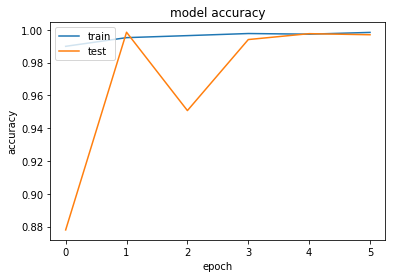

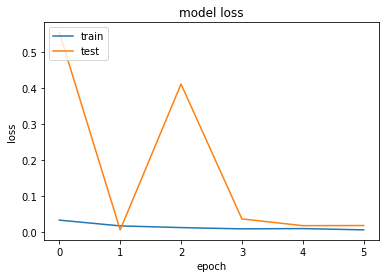

In [561]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()